# Setup

Install previous version of pytorch due to compatibility issues with fastai

In [0]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 44.7MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


Import required packages

In [0]:
import h5py
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback
from fastai.vision import *
from fastai.metrics import error_rate

# Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
from google.colab import drive

Authenticate to Google Drive to access dataset folder:

In [0]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# GoogleDrive(gauth)
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


General parameters and settings

In [0]:
mini_dataset_path = "/content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192"
model_folder_path = "/content/drive/My Drive/document-classification/models/image-classifier"

# False: skip training process and load the already learned weights to only evaluate the network
train_network = True
# True: resume the training from a checkpoint; False: start a new training
# This flag is checked only if train_network=True
resume_training = False

# Shape of the images in input to the CNN
cnn_image_shape = (224, 224)
# Number of images classes
n_classes = 16
# Batch size to be used in training
batch_size = 32

Check if GPU is available:

In [0]:
# from tensorflow.python.client import device_lib 
# display(device_lib.list_local_devices())
# assert tf.config.list_physical_devices('GPU')

# Dataset preparation

Read the csv files containing the training and validation set images paths and labels into a single dataframe, distinguishing them by _is_valid_ value.

In [0]:
df_train = pd.read_csv(os.path.join(mini_dataset_path, "train-labels.csv"), names=["image", "label"])
df_valid = pd.read_csv(os.path.join(mini_dataset_path, "valid-labels.csv"), names=["image", "label"])
df_train["is_valid"] = False
df_valid["is_valid"] = True
df_joined = pd.concat([df_train, df_valid], ignore_index=True)
print(df_joined.head())
print(df_joined.tail())

                                 image  label  is_valid
0  train/0/0/0/0/94002065_94002066.tif     10     False
1         train/0/0/0/1/2074950097.tif     10     False
2      train/0/0/0/2/50284095-4103.tif      6     False
3           train/0/0/0/3/04003306.tif     10     False
4         train/0/0/0/4/2024967978.tif     11     False
                                        image  label  is_valid
1771             valid/0/2/8/3/0060077830.tif      7      True
1772             valid/0/2/8/4/2045723775.tif     15      True
1773  valid/0/2/8/5/2062426213_2062426237.tif     12      True
1774      valid/0/2/8/6/01747683_01747694.tif     13      True
1775               valid/0/2/8/7/10395005.tif      8      True


Create a custom ImageDataBunch starting from the previous dataframe.

In [0]:
data = (ImageList.from_df(df_joined, mini_dataset_path, cols="image")#, folder=mini_dataset_path)
        .split_from_df()
        .label_from_df()
        .transform(size=cnn_image_shape, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize())

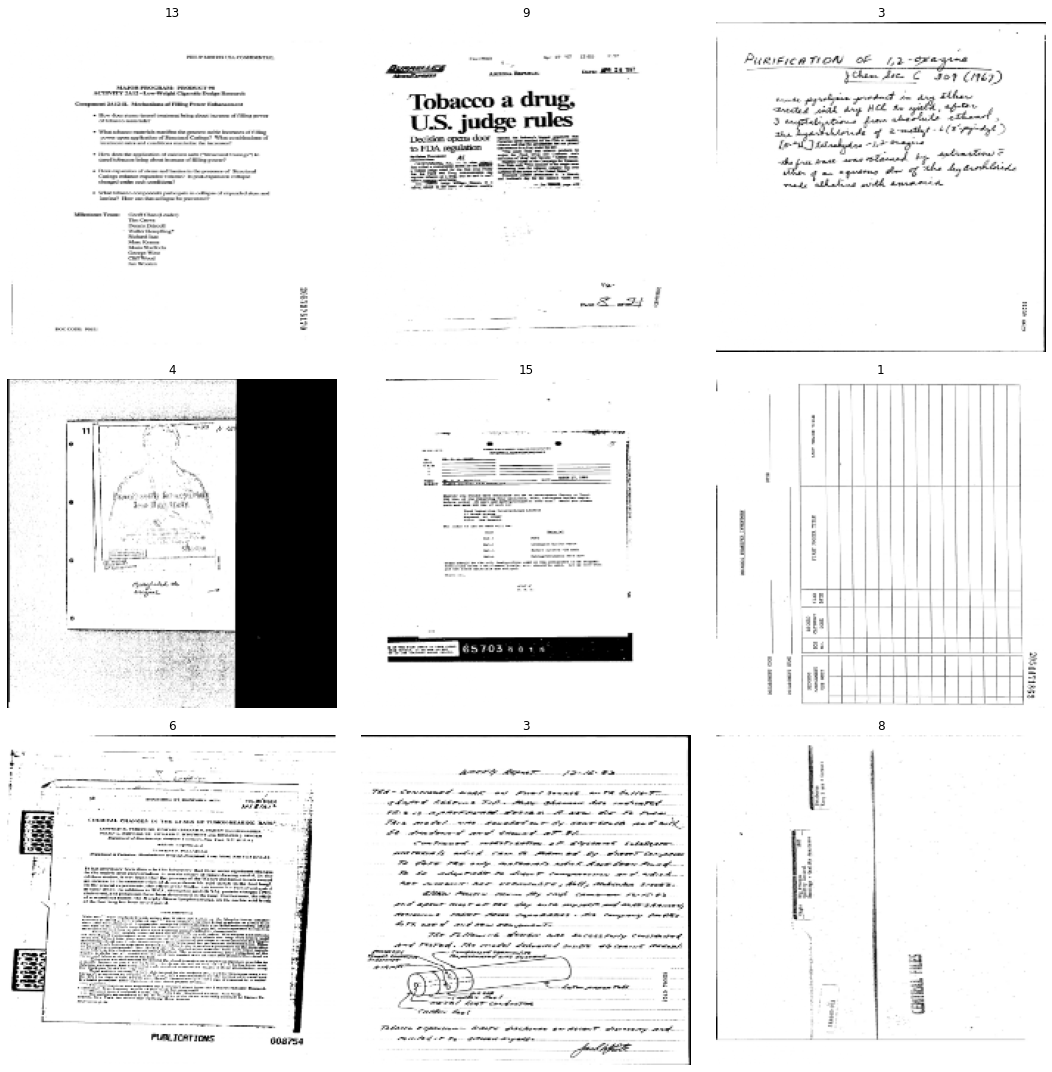

In [0]:
data.show_batch(rows=3, figsize=(15,15))

# VGG16 Training

Create the model with pretrained weights.

In [0]:
learn = cnn_learner(data, models.vgg16_bn, metrics=accuracy,
                    model_dir=model_folder_path)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 224, 224]       1,792      False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
Conv2d               [64, 224, 224]       36,928     False     
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
MaxPool2d            [64, 112, 112]       0          False     
___________________________________________________

Study the learning rate to determine a good value to use.

In [0]:
# learn.lr_find()
# learn.recorder.plot()

Find the best learning rate studying its trend (Experimental).

This function has been taken from this post: https://forums.fast.ai/t/automated-learning-rate-suggester/44199

In [0]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    print(losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

learning_rate = find_appropriate_lr(learn, plot=True)
print(f"learning rate found: {learning_rate}")

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
[0.00282  0.00659  0.006243 0.005099 0.008457 0.012288]


AssertionError: ignored

Train the network.

Create a SaveModelCallback to save the best model (based on the validation accuracy) during the training and prevent from overfitting.

In [0]:
save_model = SaveModelCallback(learn, every="improvement", monitor="accuracy", mode="max", name="best-stage-1")
learn.fit_one_cycle(75, max_lr=learning_rate, callbacks=[save_model])
print("Training completed")

epoch,train_loss,valid_loss,accuracy,time
0,3.480507,2.303749,0.322917,00:45
1,2.729551,1.973859,0.458333,00:46
2,2.254415,1.761996,0.496528,00:45
3,1.839059,1.696362,0.545139,00:45
4,1.513373,1.656962,0.541667,00:48
5,1.265672,1.703151,0.541667,00:45
6,1.087453,1.664813,0.555556,00:45
7,0.961109,1.642469,0.572917,00:45
8,0.870220,1.706692,0.572917,00:47
9,0.793307,2.148103,0.534722,00:46


Better model found at epoch 0 with accuracy value: 0.3229166567325592.
Better model found at epoch 1 with accuracy value: 0.4583333432674408.
Better model found at epoch 2 with accuracy value: 0.4965277910232544.
Better model found at epoch 3 with accuracy value: 0.5451388955116272.
Better model found at epoch 6 with accuracy value: 0.5555555820465088.
Better model found at epoch 7 with accuracy value: 0.5729166865348816.
Better model found at epoch 22 with accuracy value: 0.5798611044883728.
Better model found at epoch 28 with accuracy value: 0.6041666865348816.
Better model found at epoch 44 with accuracy value: 0.6076388955116272.
Better model found at epoch 46 with accuracy value: 0.6111111044883728.
Better model found at epoch 47 with accuracy value: 0.6458333134651184.
Better model found at epoch 61 with accuracy value: 0.6493055820465088.
Better model found at epoch 62 with accuracy value: 0.6527777910232544.
Better model found at epoch 64 with accuracy value: 0.65625.
Better mo

## Unfreezing and fine-tuning

In this section, we unfreeze the convolutional layers and fine-tune the whole model.

In [0]:
# Load the best model from the previous stage of training
learn.load("best-stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (1488 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
10,10,6,10,11
Path: /content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192;

Valid: LabelList (288 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,7,12,6,14
Path: /content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [0]:
learn.unfreeze()
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 224, 224]       1,792      True      
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
Conv2d               [64, 224, 224]       36,928     True      
______________________________________________________________________
BatchNorm2d          [64, 224, 224]       128        True      
______________________________________________________________________
ReLU                 [64, 224, 224]       0          False     
______________________________________________________________________
MaxPool2d            [64, 112, 112]       0          False     
___________________________________________________

Study the learning rate trend to appropriately set a range of values for the fine tuning process.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 6.92E-07


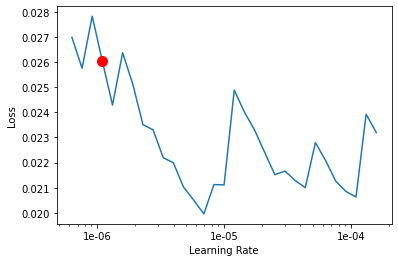

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Unfreeze the layers and train the network with a learning rate ranging from 1e-6 (for the first layer) to 1e-2 (for the last layer).

In [0]:
save_model = SaveModelCallback(learn, every="improvement", monitor="accuracy", mode="max", name="best-fine-tuning")

learn.fit_one_cycle(75, max_lr=slice(1e-6,1e-4), callbacks=[save_model])
print("Fine tuning completed")

epoch,train_loss,valid_loss,accuracy,time
0,0.018703,2.242249,0.663194,03:37
1,0.019487,2.198381,0.666667,00:45
2,0.018191,2.234839,0.673611,00:45
3,0.023151,2.256362,0.670139,00:45
4,0.021970,2.218211,0.649306,00:44
5,0.022640,2.235077,0.659722,00:44
6,0.020566,2.225733,0.656250,00:44
7,0.021932,2.256227,0.656250,00:44
8,0.015524,2.208047,0.673611,00:44
9,0.015442,2.206166,0.656250,00:44


Better model found at epoch 0 with accuracy value: 0.6631944179534912.
Better model found at epoch 1 with accuracy value: 0.6666666865348816.
Better model found at epoch 2 with accuracy value: 0.6736111044883728.
Fine tuning completed


# Results

The following cells evaluate the performance and correctness of the trained model.

Load the fine tuned model.

In [0]:
learn.load("best-fine-tuning")

Learner(data=ImageDataBunch;

Train: LabelList (1488 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
10,10,6,10,11
Path: /content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192;

Valid: LabelList (288 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,7,12,6,14
Path: /content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

See which images brings the worst classification errors.

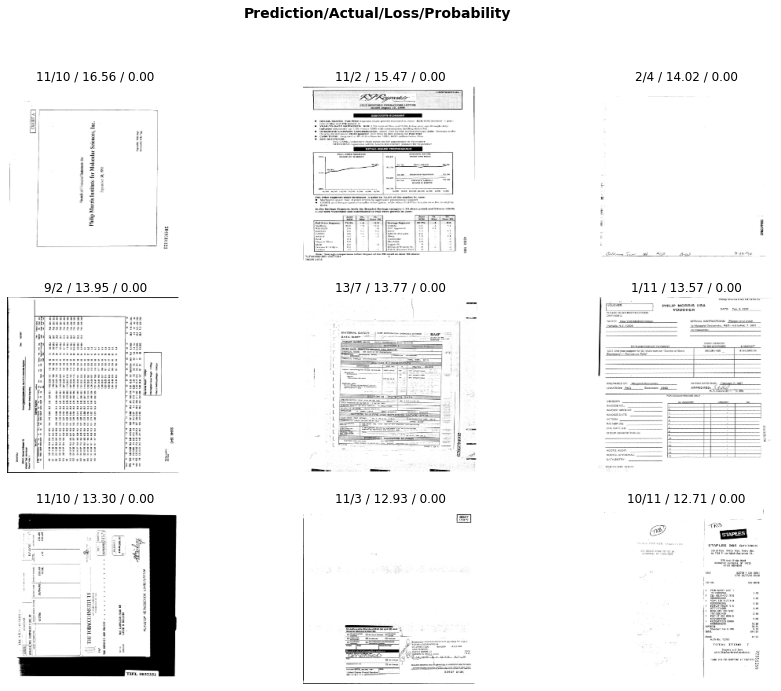

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

Confusion matrix:

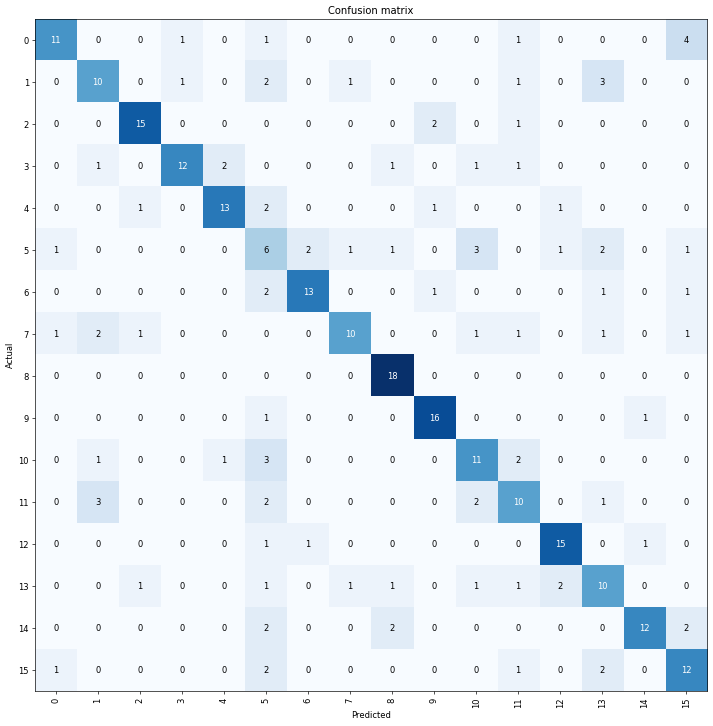

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Most confused categories:

In [0]:
interp.most_confused(min_val=2)

[(0, 15, 4),
 (1, 13, 3),
 (5, 10, 3),
 (10, 5, 3),
 (11, 1, 3),
 (1, 5, 2),
 (2, 9, 2),
 (3, 4, 2),
 (4, 5, 2),
 (5, 6, 2),
 (5, 13, 2),
 (6, 5, 2),
 (7, 1, 2),
 (10, 11, 2),
 (11, 5, 2),
 (11, 10, 2),
 (13, 12, 2),
 (14, 5, 2),
 (14, 8, 2),
 (14, 15, 2),
 (15, 5, 2),
 (15, 13, 2)]